In [8]:
import pandas as pd
from sklearn.metrics import f1_score

from lbl2vec import Lbl2Vec, Lbl2TransformerVec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [6]:
def evaluate_lbl2vec_on_dataset(dataset_name: str, n_iterations: int = 1, n_words: int = 1):
    def tokenize(doc):
        return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
    
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['tagged_docs'] = documents_df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)]), axis=1
    )
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    keywords_cached_df = pd.read_csv(f'cache/{dataset_name}_spacy_keywords.csv')
    keywords_cached_df['class_result_keywords'] = keywords_cached_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    similar_keywords = dict(zip(keywords_cached_df['class_raw_keywords'], keywords_cached_df['class_result_keywords']))
    labels_df['class_result_keywords'] = labels_df.apply(
        lambda row: similar_keywords[row['class_keywords']][:n_words], axis=1
    )
    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Evaluation
    f1_scores_train = []
    f1_scores_test = []

    for i in range(n_iterations):
        print(f'[INFO] {dataset_name} | Iteration {i+1}/{n_iterations}...' + ' ' * 20, end='\r')

        # -- Model
        lbl2vec_model = Lbl2Vec(
            keywords_list=[item for item in labels_df['class_result_keywords']], 
            tagged_documents=list(documents_df['tagged_docs'][documents_df['dataset_type'] == 'train']), 
            label_names=[item for item in labels_df['class_keywords']], 
            min_count=2,
            verbose=False
        )
        lbl2vec_model.fit()

        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=documents_df['tagged_docs'][documents_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        y_true_train = evaluation_train['class_keywords']
        y_pred_train = evaluation_train['most_similar_label']

        y_true_test = evaluation_test['class_keywords']
        y_pred_test = evaluation_test['most_similar_label']

        current_f1_score_train = f1_score(y_true_train, y_pred_train, average='micro')
        current_f1_score_test = f1_score(y_true_test, y_pred_test, average='micro')

        f1_scores_train.append(current_f1_score_train)
        f1_scores_test.append(current_f1_score_test)

        print(f'[INFO] Iteration {i+1}/{n_iterations} - Train F1 Score: {current_f1_score_train:.4f} - Test F1 Score: {current_f1_score_test:.4f}' + ' ' * 40, end='\r')

    return f1_scores_train, f1_scores_test

In [41]:
result_df = pd.DataFrame()

for dataset_name in ['BBC_News', '20NewsGroup', 'DBLP', 'M10']:
    f1_scores_train, f1_scores_test = evaluate_lbl2vec_on_dataset(dataset_name, n_iterations=10, n_words=20)

    for iter_idx in range(len(f1_scores_train)):
        for dataset_type, scores in zip(['train', 'test'], [f1_scores_train, f1_scores_test]):
            result_df = pd.concat([
                result_df, 
                pd.DataFrame({
                    'dataset': dataset_name,
                    'iteration': iter_idx + 1,
                    'Dataset Type': dataset_type,
                    'F1 score': scores[iter_idx]
                }, index=[0])
            ])

result_df.to_csv('cache/performances.csv', index=False)

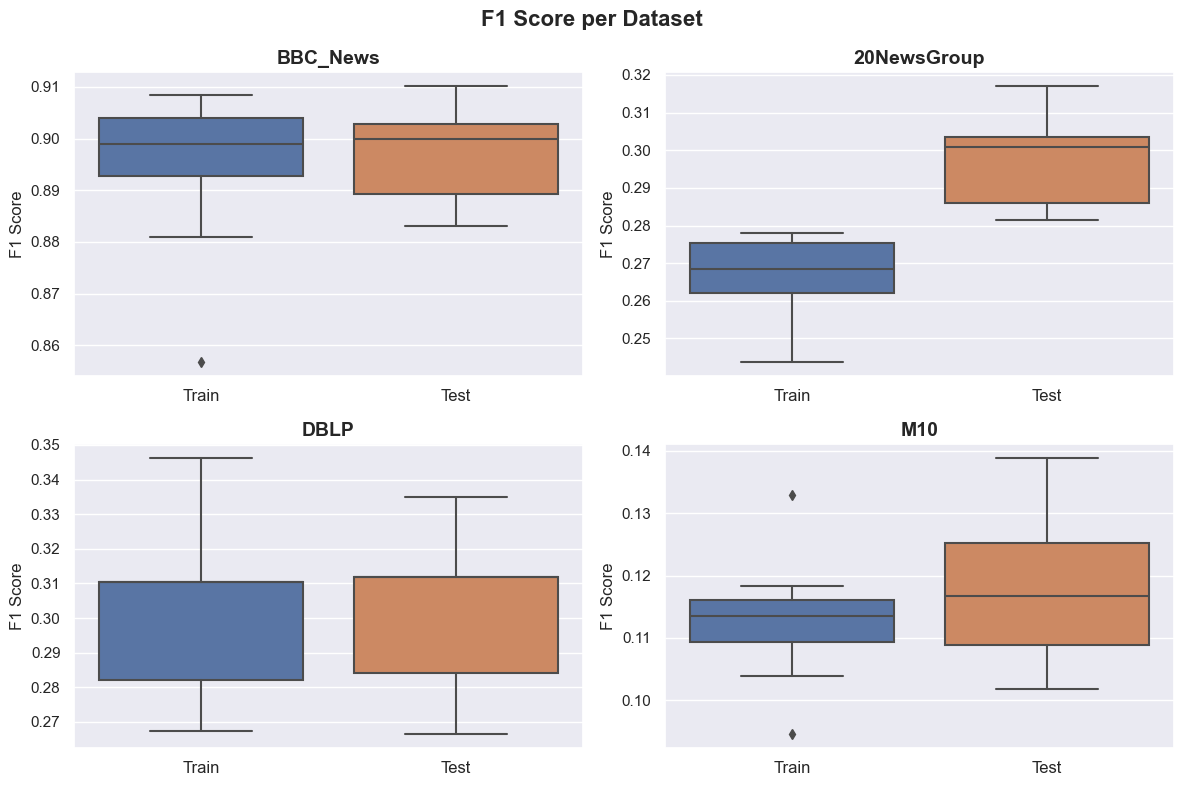

In [42]:
result_df = pd.read_csv('cache/performances.csv')

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

x, y = 0, 0

for dataset_name in result_df['dataset'].unique():
    dataset_df = result_df[result_df['dataset'] == dataset_name]

    sns.boxplot(
        data=dataset_df,
        x='Dataset Type',
        y='F1 score',
        ax=ax[x, y]
    )

    ax[x, y].set_title(dataset_name, fontsize=14, fontweight='bold')
    ax[x, y].set_xlabel('')
    ax[x, y].set_ylabel('F1 Score', fontsize=12)
    ax[x, y].set_xticklabels(['Train', 'Test'], fontsize=12)
    
    if y == 0:
        y += 1
    else:
        y = 0
        x += 1

fig.suptitle('F1 Score per Dataset', fontsize=16, fontweight='bold')

fig.tight_layout()
fig.savefig('../figures/lbl2vec_performances.png')